#  Cat Boost

The aim of this notebook is to try out XG-boost on our optimization problem. There is also some ideas and concepts that will overlap with other machine learning models. Some novel ideas related to the preprocessing step is in this file, but SHOULD be moved to a dedicated pre-processing library to make the puipeline easier to work with.

*TODO: Create a preprocessing library*

### Import the needed libraries

In [19]:

# First we will extract the data, and save it to a csv.

# Machine Learning Model
import catboost as cb

# Data Processing Tools
import numpy as np
import pandas as pd
import seaborn as sns

# Data Display Tools
import matplotlib.pyplot as plt

# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import f_regression

import feature_generation as feat_gen
import data_processing as dat_proc

%matplotlib inline



### Extract data

In [20]:
train_a = pd.read_parquet('A/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')

print(train_a.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34085 entries, 0 to 34084
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   time            34085 non-null  datetime64[us]
 1   pv_measurement  34085 non-null  float64       
dtypes: datetime64[us](1), float64(1)
memory usage: 532.7 KB
None


### Preprocessing of data
Notice that we for now have a whole block dedicated to preprocessing, but should rather be its own module.

In [21]:
X_train_estimated_a = X_train_estimated_a.drop("date_calc", axis = 1)

X = pd.concat([X_train_observed_a, X_train_estimated_a], axis = 0, ignore_index=True)

X = X.interpolate(method='linear')
X = X.bfill()

timestamps = "date_forecast"
measurements = list(X.columns.values)
measurements.remove(timestamps)

# Probable features that may be used
der_df = feat_gen.derivative_from_df(X, timestamps, measurements)
dder_df = feat_gen.derivative_from_df(X, timestamps, measurements)
int_df = feat_gen.integral_from_df(X, timestamps, measurements)
dint_df = feat_gen.double_integral_from_df(X, timestamps, measurements)
time_df = feat_gen.time_data_from_df(X, timestamps)

X = pd.concat([X, der_df, dder_df, int_df, dint_df, time_df], axis = "columns")

y = train_a.dropna()

# Additional features
der_y = feat_gen.derivative_from_df(y, "time", ["pv_measurement"])
der_y_shifted = feat_gen.shifted_values_24_h(der_y, "derivative_pv_measurement")
y_shifted =  feat_gen.shifted_values_24_h(y, "pv_measurement")

y_BIG = pd.concat([y, der_y_shifted, y_shifted])

y_BIG, X = dat_proc.data_length_matching(y, X)

y = y_BIG["pv_measurement"]
y = y.reset_index(drop = True)

y_features = y_BIG.drop('time', axis=1)
y_features = y_features.reset_index(drop = True)

X = X.reset_index(drop = True)
X = X.drop(timestamps, axis=1)

X = pd.concat([X, y_features], axis = "columns")

#X = SelectKBest(f_regression, k=12).fit_transform(X, y)

TypeError: concat() takes 1 positional argument but 2 were given

In [ ]:
# DO we get a day or the 
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()

# Fit and transform the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## AI Training: CatBoost


In [ ]:

train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function="RMSE", logging_level='Silent')

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset, verbose=False)


pred = model.predict(X_test)
mae = (mean_absolute_error(y_test, pred))
r2 = r2_score(y_test, pred)
print("Testing performance")
print("Mean Abs: {:.2f}".format(mae))
print("R2: {:.2f}".format(r2))



Testing performance
Mean Abs: 138.46
R2: 0.86


### Plotting
Adding a set of plotts to see how well the machine-learning model performs graphically.

TODO: We should probably plot the data-values that perform the worst.

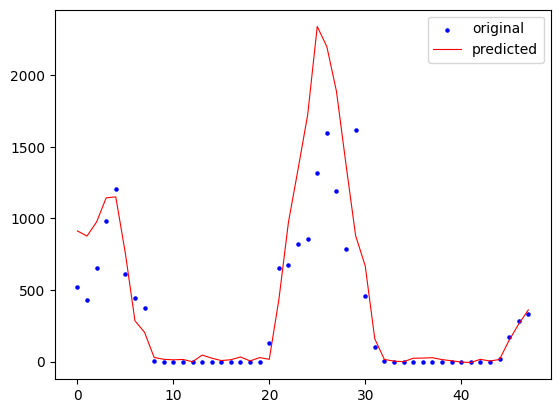

In [ ]:


x_ax = range(48)
plt.scatter(x_ax, y_test[0:48], s=5, color="blue", label="original")
plt.plot(x_ax, pred[0:48], lw=0.8, color="red", label="predicted")

plt.legend()
plt.show()
